In [24]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline


In [ ]:

print(" Đang đọc dữ liệu từ file 'original_file.csv'...")

try:
    # Đọc file dữ liệu
    df = pd.read_csv("original_file.csv")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'original_file.csv'. Hãy kiểm tra lại đường dẫn.")
    exit()

 Đang đọc dữ liệu từ file 'original_file.csv'...


In [ ]:
# Đổi tên cột để dễ xử lý trong code
column_mapping = {
    'numeric_id': 'subject_id',    # Định danh người bệnh
    'FIX_DURATION': 'duration',    # Thời gian nhìn
    'FIX_X': 'x',                  # Tọa độ X
    'FIX_PUPIL': 'pupil',          # 
    'FIX_Y': 'y',                  # Tọa độ Y
    'label': 'label'               # Nhãn (0 hoặc 1)
}

df = df.rename(columns=column_mapping)

In [ ]:
print(f"Tổng số dòng dữ liệu: {len(df)}")
df.head(10)

 Đã tải xong! Tổng số dòng dữ liệu raw: 225159


,IMAGE,FIX_INDEX,duration,x,y,pupil,source_file,subject_id,label,image_id
0,outman_054.jpg,1,205,518.5,371.3,1177,000.xlsx,0,0,53
1,outman_054.jpg,2,90,275.1,282.2,1262,000.xlsx,0,0,53
2,outman_054.jpg,3,305,600.3,271.1,1265,000.xlsx,0,0,53
3,outman_054.jpg,4,269,635.2,269.2,1326,000.xlsx,0,0,53
4,outman_054.jpg,5,318,597.3,266.0,1366,000.xlsx,0,0,53
5,outman_054.jpg,6,585,575.4,269.3,1442,000.xlsx,0,0,53
6,outman_054.jpg,7,531,610.9,274.1,1508,000.xlsx,0,0,53
7,outman_054.jpg,8,336,595.0,333.7,1577,000.xlsx,0,0,53
8,outman_054.jpg,9,400,597.8,599.6,1687,000.xlsx,0,0,53
9,outman_054.jpg,10,325,550.1,580.0,1756,000.xlsx,0,0,53


In [ ]:
def extract_features(df_raw):
    print("⚙️ Đang trích xuất đặc trưng ")
    features_list = []
    
    grouped = df_raw.groupby('subject_id')
    
    for sub_id, group in grouped:
        if len(group) < 2: continue
            
        label = group['label'].iloc[0]
        
        # --- A. ĐẶC TRƯNG THỜI GIAN ---
        dur_mean = group['duration'].mean()
        dur_std = group['duration'].std()
        
        # --- B. ĐẶC TRƯNG KHÔNG GIAN ---
        x_std = group['x'].std()
        y_std = group['y'].std()
        
        # --- C. ĐẶC TRƯNG CHUYỂN ĐỘNG (SACCADE) ---
        dx = group['x'].diff().fillna(0)
        dy = group['y'].diff().fillna(0)
        sac_amp = np.sqrt(dx**2 + dy**2)
        
        sac_mean = sac_amp.mean()
        sac_std = sac_amp.std()
        
        # --- D. ĐẶC TRƯNG ĐỒNG TỬ (PUPIL) - MỚI ---
        # Đồng tử giãn/co bất thường là dấu hiệu quan trọng
        pupil_mean = group['pupil'].mean() # Kích thước trung bình
        pupil_std = group['pupil'].std()   # Độ biến động (co giãn nhiều hay ít)
        pupil_max = group['pupil'].max()   # Kích thước lớn nhất (lúc căng thẳng nhất)
        
        # Tổng hợp
        features_list.append({
            'subject_id': sub_id,
            # Time
            'dur_mean': dur_mean,
            'dur_std': dur_std,
            # Space
            'x_dispersion': x_std,
            'y_dispersion': y_std,
            # Movement
            'sac_mean': sac_mean,
            'sac_std': sac_std,
            # Pupil (Đã thêm)
            'pupil_mean': pupil_mean,
            'pupil_std': pupil_std,
            'pupil_max': pupil_max,
            # Target
            'label': label
        })
        
    return pd.DataFrame(features_list)

# Thực hiện
df_features = extract_features(df)
print(f" Đã trích xuất xong! Kích thước dữ liệu huấn luyện: {df_features.shape}")
print(df_features.head())

In [29]:
# Tách Feature (X) và Label (y)
X = df_features.drop(columns=['subject_id', 'label'])
y = df_features['label']

# Chia tập Train (80%) và Test (20%)
# stratify=y giúp đảm bảo tỉ lệ bệnh/thường trong 2 tập là như nhau
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f" Dữ liệu Train: {len(X_train)} người")
print(f" Dữ liệu Test:  {len(X_test)} người")

# Tạo Pipeline: Chuẩn hóa dữ liệu (StandardScaler) -> SVM
# SVM rất nhạy cảm với biên độ dữ liệu nên BẮT BUỘC phải có StandardScaler
model = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
)

print("\n Đang huấn luyện mô hình SVM...")
model.fit(X_train, y_train)
print(" Huấn luyện hoàn tất!")
print("\n" + "="*30)
print("KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST")
print("="*30)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f" ĐỘ CHÍNH XÁC (ACCURACY): {acc:.4f} ({acc*100:.2f}%)")
print("\n Báo cáo chi tiết:")
print(classification_report(y_test, y_pred))


 Dữ liệu Train: 128 người
 Dữ liệu Test:  32 người

 Đang huấn luyện mô hình SVM...
 Huấn luyện hoàn tất!

KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST
 ĐỘ CHÍNH XÁC (ACCURACY): 0.6875 (68.75%)

 Báo cáo chi tiết:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        16
           1       0.71      0.62      0.67        16

    accuracy                           0.69        32
   macro avg       0.69      0.69      0.69        32
weighted avg       0.69      0.69      0.69        32



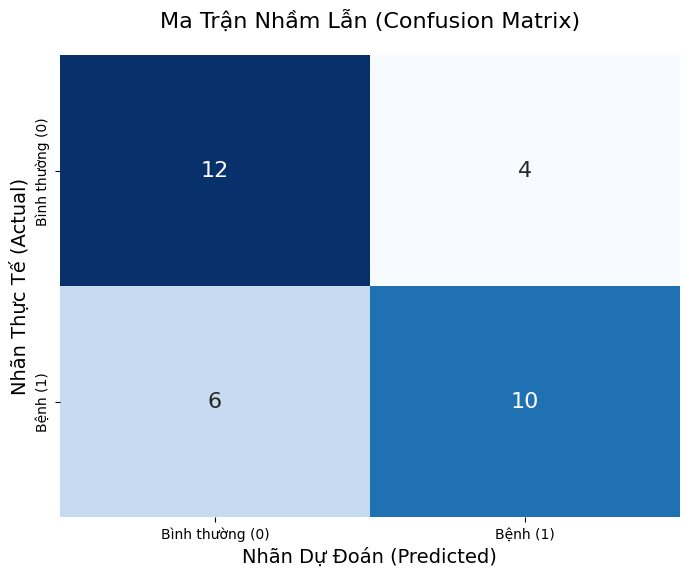

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# 2. Thiết lập hình vẽ
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Bình thường (0)', 'Bệnh (1)'],
            yticklabels=['Bình thường (0)', 'Bệnh (1)'],
            annot_kws={"size": 16}) # Cỡ chữ số to rõ

# 4. Trang trí thêm
plt.title('Ma Trận Nhầm Lẫn (Confusion Matrix)', fontsize=16, pad=20)
plt.xlabel('Nhãn Dự Đoán (Predicted)', fontsize=14)
plt.ylabel('Nhãn Thực Tế (Actual)', fontsize=14)

# Hiển thị
plt.show()